<a href="https://colab.research.google.com/github/drwatson93/Pneumonia-Detection-using-CNN/blob/main/Pneumonia_Detection_using_TensorFlow_Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
! pip install kaggle

In [2]:
#@title
! mkdir ~/.kaggle

In [3]:
#@title
! cp kaggle.json ~/.kaggle/

In [4]:
#@title
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
#@title
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:44<00:00, 31.4MB/s]
100% 2.29G/2.29G [00:44<00:00, 55.1MB/s]


In [ ]:
#@title
! unzip chest-xray-pneumonia
#! unzip ex_test

# First - What is Pneumonia?
Pneumonia is a severe lung infection, where it causes the tiny air sacs in the lungs to be inflamed and filled with fluid or pus. Patients with pneumonia may need to be hospitalized or admitted to the intensive care unit (ICU).Diagnosis is often based on symptoms and physical examination. Chest X-rays may help confirm the diagnosis.

<center><img src="https://raw.githubusercontent.com/drwatson93/Pneumonia-Detection-using-CNN/main/download.png"></img></center>

Some facts about pneumonia:
* Pneumonia is the world’s leading cause of death among children under the age of 5.
* Pneumonia is the most common reason for US children to be hospitalized.
* For US adults, pneumonia is the most common cause of hospital admissions other than women giving birth.

Source: American Thoracic Society. Top 20 Pneumonia Facts — 2019. https://www.thoracic.org/patients/patient-resources/resources/top-pneumonia-facts.pdf

How to detect pneumonia?
Now we know that pneumonia is a common illness that affects many people each year in the U.S. and around the world. How do we usually detect this disease?

It turns out that chest X-rays have long been considered the best tool to detect any form of pneumonia³. However, studies have shown that even experienced radiologists often have a hard time correctly identify whether something is an infiltrate (a substance denser than air, such as pus or fluid) on the X-Ray⁴. This causes delays in diagnosis, which increases the disease severity and associated mortality rate.

In [7]:
# necessary python libraries
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data visualization and Chart creation libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob

# Image scanning libraries
from skimage import color, exposure
from sklearn.metrics import classification_report

# file directory libraries to manipulate diracturies for saving checkpoints with in our model.
import os
import cv2

# Setting the same seed for repeatability

seed = 64

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


In [8]:
# Path where source data is located ounce extracted from the kaggle database.
data_path = '/content/chest_xray/'

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

# Compressing the image size to conserve processsing cost and expediate model prediction.
img_size = 200

In [9]:
#Function for reading data from folders.
#Returns numpy array [img, label]
labels = ['PNEUMONIA', 'NORMAL']

def read_data(data_paths):
    for data_path in data_paths:
        images = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [10]:
# Seperating training and test data. Test and validation were merge together as the validation folder only contained 16 images
train = read_data([train_path])
test = read_data([val_path, test_path])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
# Shuffling the dataset 10 times.
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [12]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [13]:
train_df['label'].head()

0       NORMAL
1       NORMAL
2    PNEUMONIA
3       NORMAL
4       NORMAL
Name: label, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


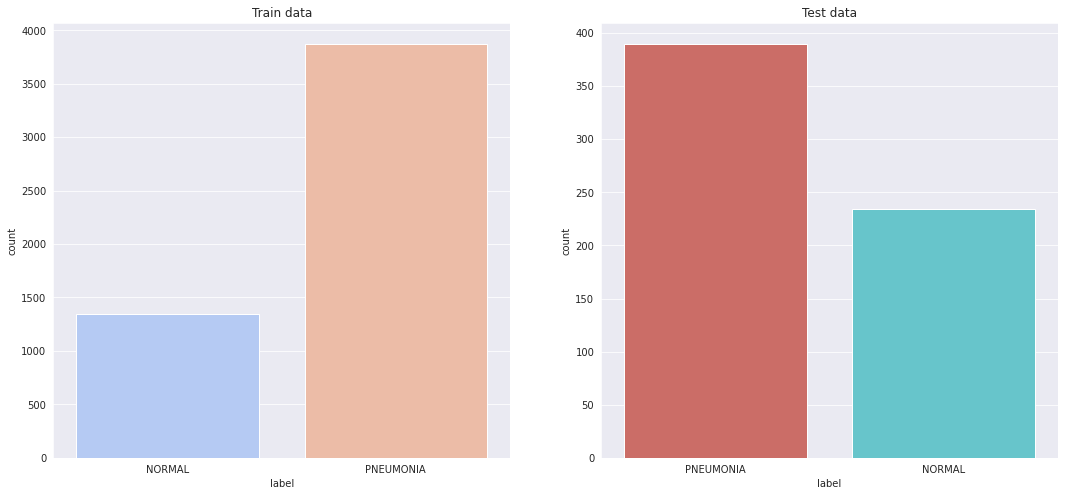

In [14]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

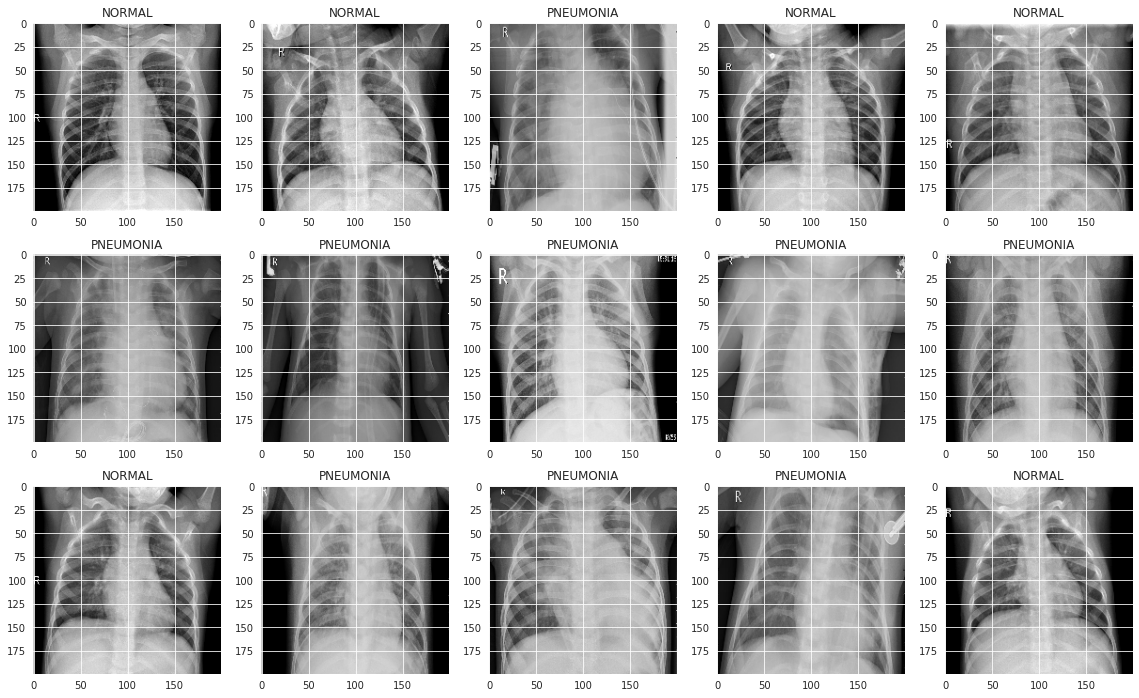

In [15]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

# Data preprocessing

In [16]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

#Function for dividing data into arrays X and y
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

# Split data
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

#  Grayscale conversion, normalization and table reshaping function for MLP
def preprocesing_to_mlp(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size * img_size).astype('float32')
    
    # Data Normalization [0, 1]
    data1 /= 255
    
    return data1

#Function to drawing learning curve history learning neural network
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()


In [17]:
X_train = preprocesing_to_mlp(X_train)
X_test = preprocesing_to_mlp(X_test)

In [18]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

# MLP ([Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))

#### Structure

Firstly, let's think how the network should look like. It will have three layers:

1. Input Layer
1. Hidden Layer
1. Output Layer

Input layer has 200 * 200 pixels reshape to vector

Hidden layer has a lot of neurons

Output layer has 2 neurons: pneumonia / normal

![](https://austingwalters.com/wp-content/uploads/2018/12/mlp.png)

### Callbacks
* EarlyStopping (Stop training when a monitored metric has stopped improving)

* ReduceLROnPlateau (Reduce learning rate when a metric has stopped improving)

* ModelCheckpoint (Callback to save the Keras model or model weights at some frequency)

In [19]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('/content/working/model.best1.hdf5',monitor='loss', save_best_only=True) # saving the best model
]

#### First model

In [20]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(1024, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [21]:
model = get_mlp()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              40961024  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,963,074
Trainable params: 40,963,074
Non-trainable params: 0
_________________________________________________________________


In [22]:
#Fitting the model
learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 40, verbose = 2,
          callbacks = callbacks1,
          validation_data=(X_test, y_test));

Epoch 1/40
82/82 - 4s - loss: 0.3879 - accuracy: 0.8236 - val_loss: 0.4318 - val_accuracy: 0.7724
Epoch 2/40
82/82 - 2s - loss: 0.1841 - accuracy: 0.9321 - val_loss: 0.5213 - val_accuracy: 0.7660
Epoch 3/40
82/82 - 2s - loss: 0.1537 - accuracy: 0.9400 - val_loss: 0.4416 - val_accuracy: 0.7997
Epoch 4/40
82/82 - 2s - loss: 0.1349 - accuracy: 0.9492 - val_loss: 0.9694 - val_accuracy: 0.7099
Epoch 5/40
82/82 - 2s - loss: 0.1391 - accuracy: 0.9450 - val_loss: 0.5905 - val_accuracy: 0.7772
Epoch 6/40
82/82 - 2s - loss: 0.1266 - accuracy: 0.9496 - val_loss: 0.7607 - val_accuracy: 0.7516
Epoch 7/40
82/82 - 2s - loss: 0.1143 - accuracy: 0.9555 - val_loss: 0.5047 - val_accuracy: 0.8029
Epoch 8/40
82/82 - 2s - loss: 0.1100 - accuracy: 0.9597 - val_loss: 0.7380 - val_accuracy: 0.7596
Epoch 9/40
82/82 - 2s - loss: 0.1131 - accuracy: 0.9597 - val_loss: 0.9299 - val_accuracy: 0.7276
Epoch 10/40
82/82 - 2s - loss: 0.1037 - accuracy: 0.9628 - val_loss: 0.8396 - val_accuracy: 0.7484
Epoch 11/40
82/82 -

In [23]:
# Loading the best model in terms of the loss metric
model = load_model('/content/working/model.best1.hdf5')

#Evaluation
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 89.37463164329529%
Test accuracy: 75.0%
MLP Error: 25.00%


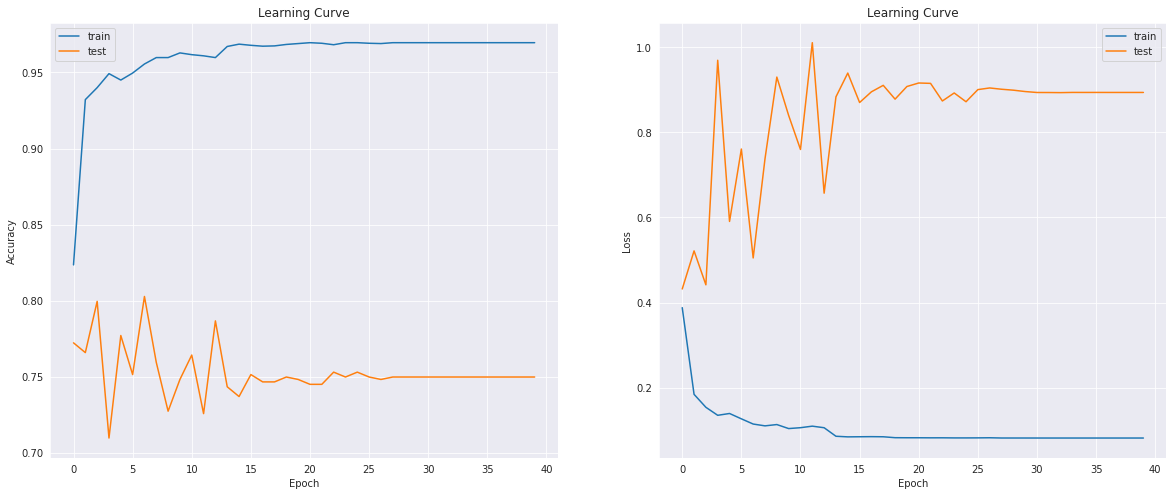

In [24]:
draw_learning_curve(learning_history)

# CNN ([Convolutional_neural_network](https://en.wikipedia.org/wiki/Convolutional_neural_network))

![](https://www.mdpi.com/diagnostics/diagnostics-10-00417/article_deploy/html/images/diagnostics-10-00417-g001.png)

Simple sequential model is used, starting with 5 double convolutional networks of kernel size **(3, 3)** and max pooling with pool size **(2, 2)**. 

Additionally has batch normalization and dropout

# Data preparing for CNN

In [25]:
#We need to rehaspe data again
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [26]:
#Grayscale conversion, normalization and table reshaping function for CNN
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [27]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [28]:
num_classes = y_train.shape[1]

In [29]:
input_shape = (img_size, img_size, 1)

In [30]:
callbacks2 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('/content/model.best2.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [31]:
num_pixels 

40000

#### First model CNN

In [32]:
def get_modelcnn():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [33]:
model = get_modelcnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)     

#### Fitting the model

In [34]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks2,
          validation_data = (X_test, y_test))

Epoch 1/100
82/82 [==============================] - 45s 314ms/step - loss: 1.2013 - accuracy: 0.7071 - val_loss: 7.6301 - val_accuracy: 0.6250
Epoch 2/100
82/82 [==============================] - 22s 270ms/step - loss: 0.3463 - accuracy: 0.8558 - val_loss: 15.2327 - val_accuracy: 0.6250
Epoch 3/100
82/82 [==============================] - 22s 271ms/step - loss: 0.2912 - accuracy: 0.8884 - val_loss: 14.8707 - val_accuracy: 0.6250
Epoch 4/100
82/82 [==============================] - 22s 271ms/step - loss: 0.2191 - accuracy: 0.9231 - val_loss: 17.7495 - val_accuracy: 0.6250
Epoch 5/100
82/82 [==============================] - 22s 271ms/step - loss: 0.1668 - accuracy: 0.9410 - val_loss: 20.2228 - val_accuracy: 0.6250
Epoch 6/100
82/82 [==============================] - 22s 266ms/step - loss: 0.1542 - accuracy: 0.9475 - val_loss: 14.9682 - val_accuracy: 0.6250
Epoch 7/100
82/82 [==============================] - 22s 271ms/step - loss: 0.1362 - accuracy: 0.9542 - val_loss: 15.6494 - val_acc

In [35]:
model = load_model('/content/model.best2.hdf5')

In [36]:
# Evaluation
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 322.21128940582275%
Test accuracy: 73.71794581413269%
MLP Error: 26.28%


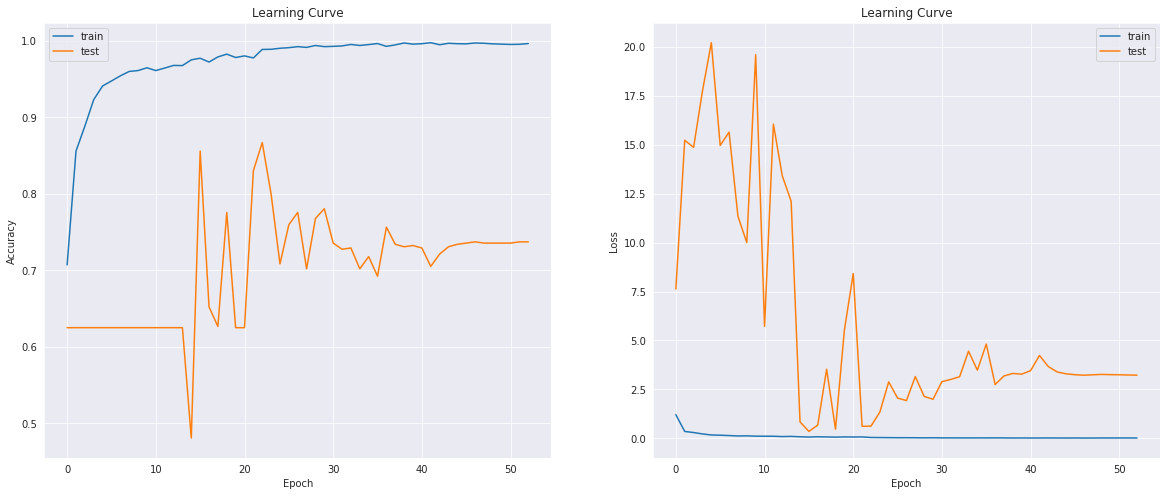

In [37]:
draw_learning_curve(learning_history)

# Data Augmentation

I will try to improve the result by expanding the data.

#### Data augmentation:
* Randomly shift images horizontally by 10% of the width

* Randomly shift images vertically by 10% of the height

* Randomly rotate images by 10 degrees

* Randomly Zoom by 10% some images

In [38]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg

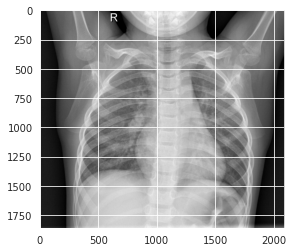

In [39]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from matplotlib.pyplot import figure

img = load_img('/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
plt.imshow(img)

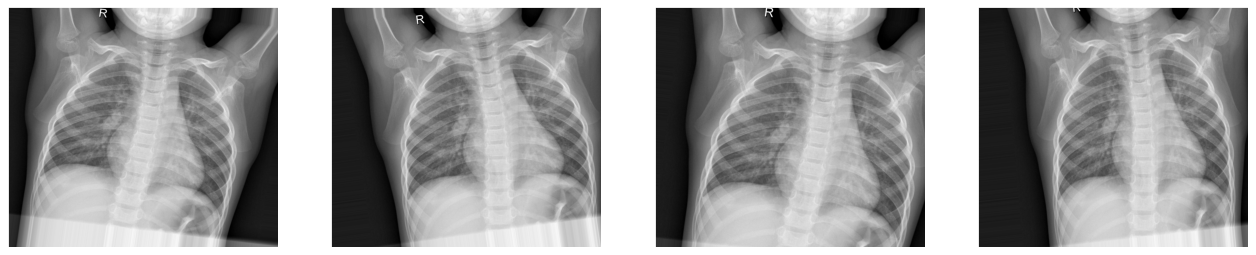

In [40]:
data = img_to_array(img)
samples = expand_dims(data, 0)

#setting an array from which the algorith will randomly choose
datagen = ImageDataGenerator(featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

_ = datagen.flow(samples, batch_size=1)

figure(figsize=(20, 12), dpi=80)

for i in range(4):
    batch = _.next()
    image = batch[0].astype('uint8')
    plt.subplot(140 + 1 + i)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [41]:
callbacks3 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('/content/model.best3.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

#### Second model CNN

It is very similar to first model, I'm changing only weight in dropout and add layer

In [42]:
def get_modelcnn_v2():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),
       
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(num_classes, activation = "softmax")
        
    ])

In [43]:
model = get_modelcnn_v2()
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)     

#### Fitting the model

In [44]:
learning_history = model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks3,
                        )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
163/163 [==============================] - 30s 170ms/step - loss: 0.5224 - accuracy: 0.7759 - val_loss: 0.6769 - val_accuracy: 0.6250
Epoch 2/100
163/163 [==============================] - 27s 166ms/step - loss: 0.2719 - accuracy: 0.8995 - val_loss: 2.9451 - val_accuracy: 0.6250
Epoch 3/100
163/163 [==============================] - 27s 166ms/step - loss: 0.2096 - accuracy: 0.9185 - val_loss: 1.9664 - val_accuracy: 0.6250
Epoch 4/100
163/163 [==============================] - 27s 165ms/step - loss: 0.1867 - accuracy: 0.9300 - val_loss: 2.1016 - val_accuracy: 0.6250
Epoch 5/100
163/163 [==============================] - 27s 165ms/step - loss: 0.1756 - accuracy: 0.9371 - val_loss: 8.8856 - val_accuracy: 0.6250
Epoch 6/100
163/163 [==============================] - 27s 165ms/step - loss: 0.1618 - accuracy: 0.9375 - val_loss: 0.9473 - val_accuracy: 0.7404
Epoch 7/100
163/163 [==============================] - 27s 165ms/step - loss: 0.1584 - accuracy: 0.9411 - val_loss: 1.2153 -

In [45]:
model = load_model('/content/model.best3.hdf5')

In [46]:
# Evaluate
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 30.420175194740295%
Test accuracy: 90.06410241127014%
MLP Error: 9.94%


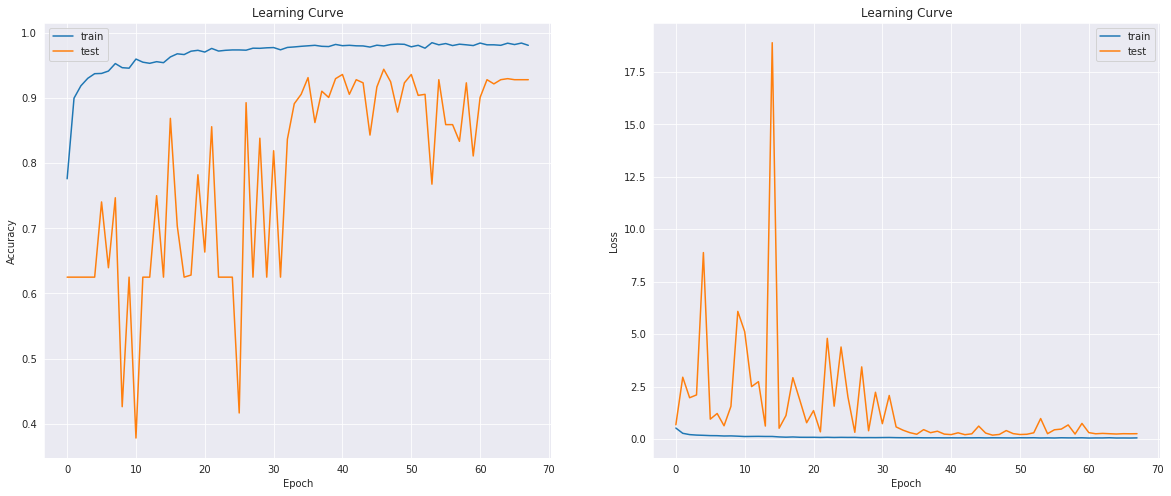

In [47]:
draw_learning_curve(learning_history)

In [48]:
# Let's see where the model was invalid
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [49]:
y_pre_test = np.argmax(y_test, axis = 1)

In [50]:
def show_condition(num):
    if num == 0:
        return 'NORMAL'
    return 'PNEUMONIA'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


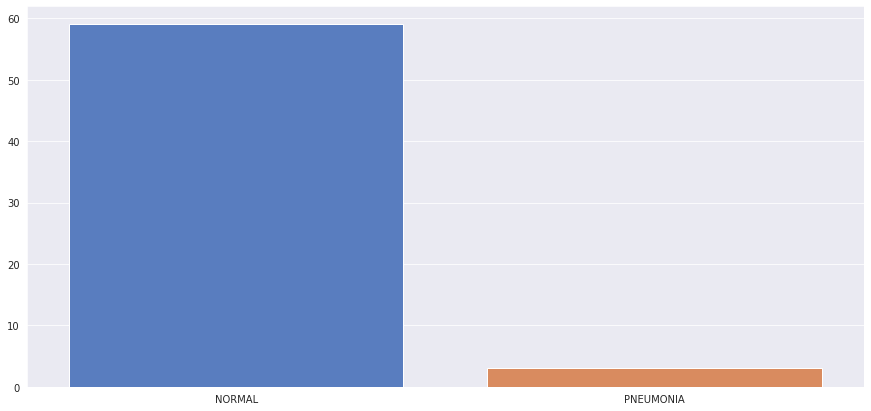

In [51]:
# Let's see the graph with the error amount for each label.
cnt_error = []
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if a == b: continue
    cnt_error.append(a)# test

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
sns.barplot([show_condition(x) for x in cnt_error[0]], cnt_error[1], palette="muted")
plt.show()

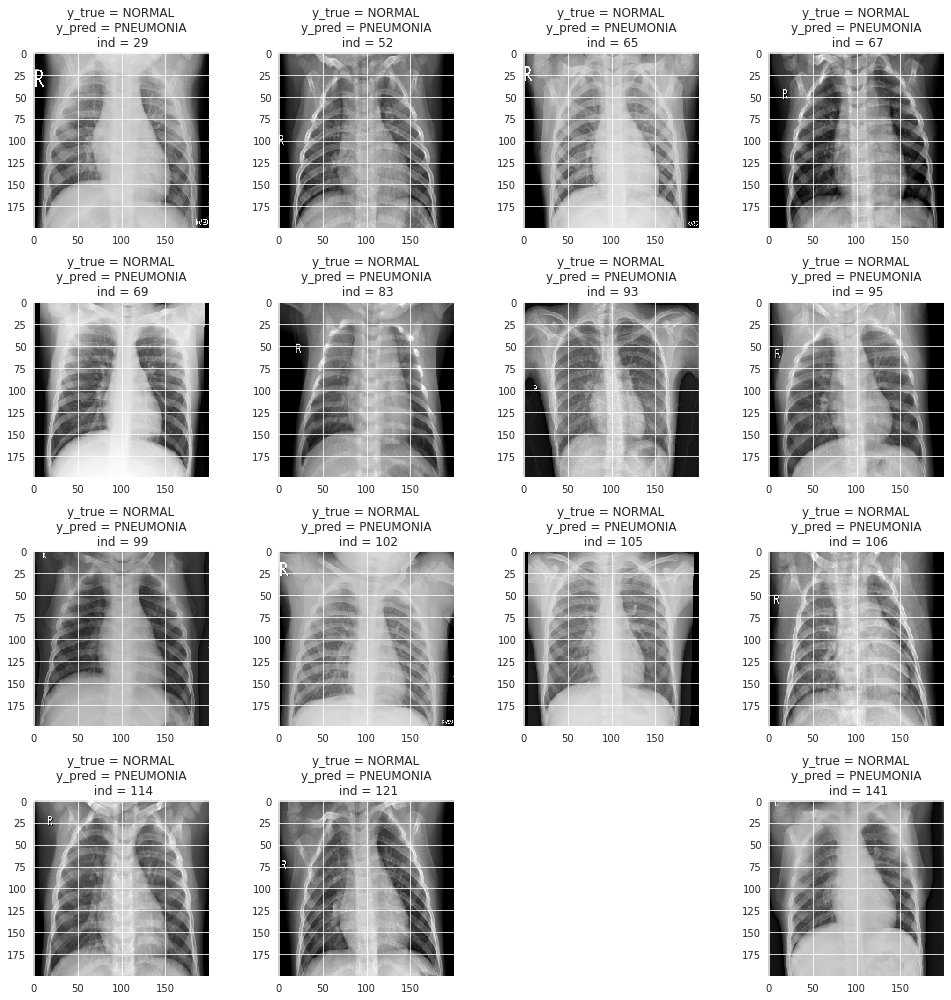

In [52]:
# Let's show images
cnt_ind = 1
list_idx = []
fig = plt.figure(figsize=(14, 14))
X_test_plot = X_test.reshape(-1, img_size, img_size)
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if(cnt_ind > 16):break
    if a == b: continue
    plt.subplot(4, 4, cnt_ind)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true = {0}\ny_pred = {1}\n ind = {2}'.format(show_condition(a), show_condition(b), idx))
    plt.tight_layout()
    list_idx.append(idx)
    cnt_ind += 1

# Summary
The model is wrong when the patient has pneumonia and is diagnosed as healthy.

This is not good, but it occurs in less than 10% of the patients studied. 

It is quite possible that the doctor would not be sure of these cases either. 

By collecting more data from different people in different hospitals, from different parts of the world, we can generalize the data and increase the accuracy of diagnosis. 

In addition, this model can serve as a screening test for patients because, as shown in the graph, when the model recognizes a person with pneumonia is almost certain.

### Achievements in the notebook

In [53]:
print(classification_report(y_pre_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       234
           1       0.87      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.93      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



In [54]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pre_test, y_pred)
#cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

Text(0.5, 69.0, 'Predicted')

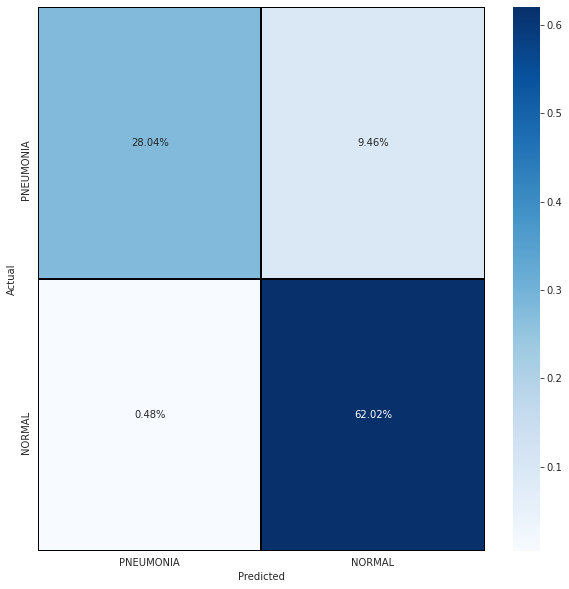

In [56]:
plt.figure(figsize = (10,10))
sns.heatmap(cm/np.sum(cm),
            cmap= "Blues", 
            linecolor = 'black' , 
            linewidth = 1 , 
            annot = True, 
            fmt='.2%',
            xticklabels = labels,
            yticklabels = labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')

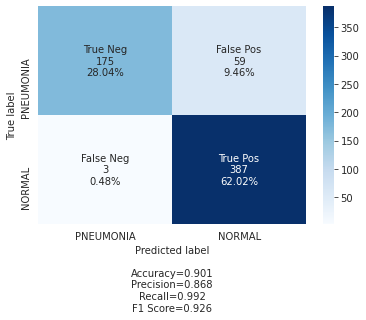

In [57]:
heatmap_labels = ['True Neg','False Pos','False Neg','True Pos']
categories = labels

make_confusion_matrix(cm, 
                      group_names=heatmap_labels,
                      categories=categories, 
                      cmap='Blues')

<center><img src="https://raw.githubusercontent.com/drwatson93/Pneumonia-Detection-using-CNN/main/Capture.PNG"></img></center>